In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#loading the stopwords library and the nltk to be used for the text preprocessing
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/eosamau/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/eosamau/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
train_data = pd.read_csv('drugsComTrain_raw.tsv', sep='\t')
test_data = pd.read_csv('drugsComTest_raw.tsv', sep='\t')
train_data.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37


In [5]:
train_data['condition'].value_counts()

condition
Birth Control                                              28788
Depression                                                  9069
Pain                                                        6145
Anxiety                                                     5904
Acne                                                        5588
                                                           ...  
Dissociative Identity Disorde                                  1
Hydrocephalus                                                  1
Hyperlipoproteinemia Type III, Elevated beta-VLDL   IDL        1
Q Feve                                                         1
Neutropenia                                                    1
Name: count, Length: 884, dtype: int64

In [6]:
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import re



def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    ps = PorterStemmer()
    tokens = [ps.stem(word) for word in tokens]
    return ' '.join(tokens) #--- Joins the token into a simple word. 

train_data['processed_review'] = train_data['review'].apply(preprocess_text)
test_data['processed_review'] = test_data['review'].apply(preprocess_text)
train_data['processed_review'].head()

0           side effect take combin bystol mg fish oil
1    son halfway fourth week intuniv becam concern ...
2    use take anoth oral contracept pill cycl happi...
3    first time use form birth control im glad went...
4    suboxon complet turn life around feel healthie...
Name: processed_review, dtype: object

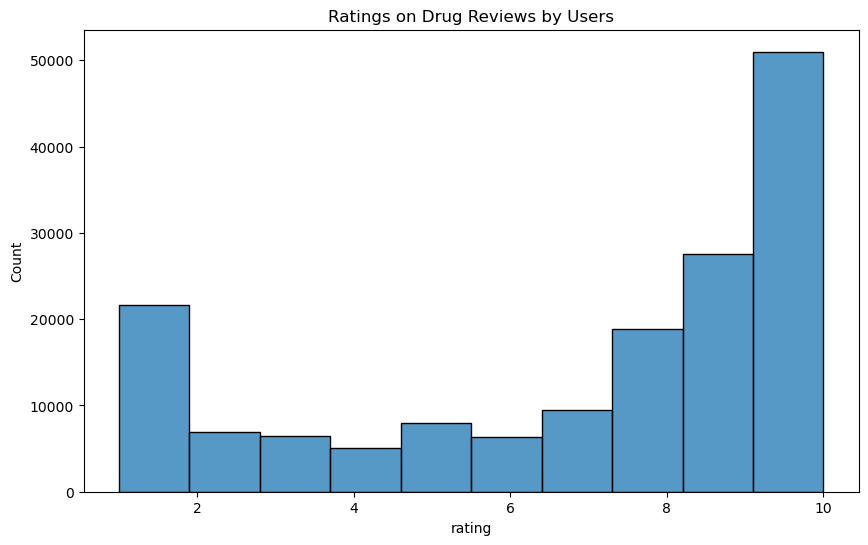

In [7]:
plt.figure(figsize=(10, 6))
sns.histplot(train_data['rating'], bins=10)
plt.title('Ratings on Drug Reviews by Users')
plt.savefig('histogram_of_ratings.png')
plt.show()

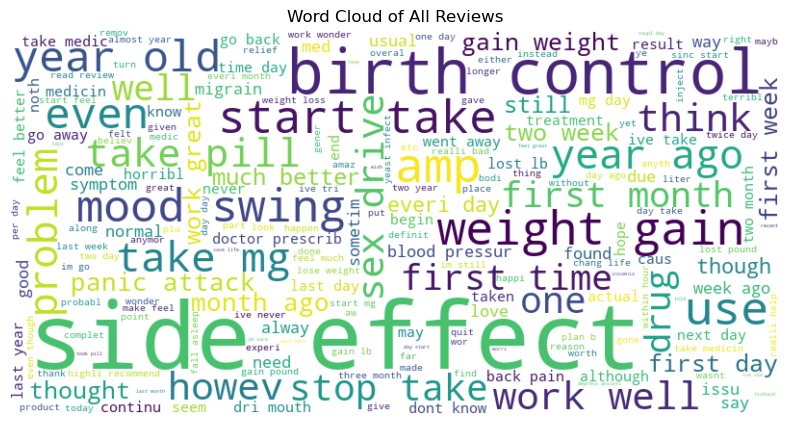

In [8]:
#creating a word cloud to visualize the most used words in 215,063 drug reviews by the users
from wordcloud import WordCloud

all_words = ' '.join(train_data['processed_review'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

plt.figure(figsize=(10, 5))

plt.imshow(wordcloud, interpolation='bilinear')

plt.axis('off')

plt.title('Word Cloud of All Reviews')

plt.savefig('wordcloud.png')
plt.show()

In [9]:
#---------TF-IDF -----------#

#Now in this stage we want to assign importance to words in the training data by using the TF IDF method which 
#can help distinguish words in accordance to how they are most used for ratings

#tfidf = TfidfVectorizer(max_features=5000)
#X_tfidf = tfidf.fit_transform(train_data['processed_review'])
#y = train_data['rating']
#X_train_tfidf, X_val_tfidf, y_train, y_val = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)



## Text Processing and Feature Engineering

In [10]:
import gensim

# Training a Word2Vec model tokenized reviews using the SkipGram method
word2vec_model = gensim.models.Word2Vec(sentences=train_data['processed_review'], vector_size=300, window=5, min_count=2, sg=1, workers=4)


def get_average_word2vec(tokens_list, model, vector_size):
    
    valid_words = [word for word in tokens_list if word in model.wv.key_to_index] #vocabulary from word2Vec model
    
    if not valid_words: 
        return np.zeros(vector_size) #we want to return a zero vector for the doc in case no valid words are found in the doc
    
    return np.mean(model.wv[valid_words], axis=0) # the entire review is converted into a single vector, 
                                                  #instead of different vectors for each word in the document

vector_size = word2vec_model.vector_size
train_data['word2vec_review'] = train_data['processed_review'].apply(lambda x: get_average_word2vec(x, word2vec_model, vector_size))


X_word2vec = np.vstack(train_data['word2vec_review'].values) # To convert the into a numpy array


In [11]:
def categorize_sentiment(rating):
    if rating <= 4:
        return 0  # Negative
    elif rating <= 7:
        return 1  # Neutral
    else:
        return 2  # Positive
    
train_data['sentiment'] = train_data['rating'].apply(categorize_sentiment)
y = train_data['sentiment']

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


X_train, X_test, y_train, y_test = train_test_split(X_word2vec, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Model Training and Evaluation

In [13]:
X_train_scaled.shape

(129037, 300)

#### Randomly reducing the principal components to 10 and evaluating the XGBoost Model

In [34]:

from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

pca = PCA(n_components=10)  
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)


xgb_classifier = XGBClassifier(n_estimators=100, 
                               learning_rate=0.1, random_state = 42, n_jobs=-1)  
xgb_classifier.fit(X_train_scaled, y_train)
xgb_pred = xgb_classifier.predict(X_test_scaled)

print("\XGBoost Classifier Results:")
print(classification_report(y_test, xgb_pred, target_names=['Negative', 'Neutral', 'Positive']))

\XGBoost Classifier Results:
              precision    recall  f1-score   support

    Negative       0.61      0.12      0.19      7961
     Neutral       0.83      0.00      0.01      4899
    Positive       0.62      0.98      0.76     19400

    accuracy                           0.62     32260
   macro avg       0.69      0.37      0.32     32260
weighted avg       0.65      0.62      0.51     32260



In [18]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=5,
                                           n_jobs=-1, random_state=42)
rf_classifier.fit(X_train_scaled, y_train)
rf_pred = rf_classifier.predict(X_test_scaled)

print("\nRandom Forest Classifier Results:")
print(classification_report(y_test, rf_pred, target_names=['Negative', 'Neutral', 'Positive']))


Random Forest Classifier Results:
              precision    recall  f1-score   support

    Negative       1.00      0.00      0.00      7961
     Neutral       0.00      0.00      0.00      4899
    Positive       0.60      1.00      0.75     19400

    accuracy                           0.60     32260
   macro avg       0.53      0.33      0.25     32260
weighted avg       0.61      0.60      0.45     32260



/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Without wasting compute time with max_depth, it appears the overall accurcay is around 62% when XGBoost and RandomForest are used for the classification. We will now proceed to use the optimal number of principal components to see if the accurcay improves. After several iterations it appears the XGBoost performs better than the Random Forest Classifier. 

Also, we notice here that there are class imbalances and there we need to adjust the data to ensure there is some balance.

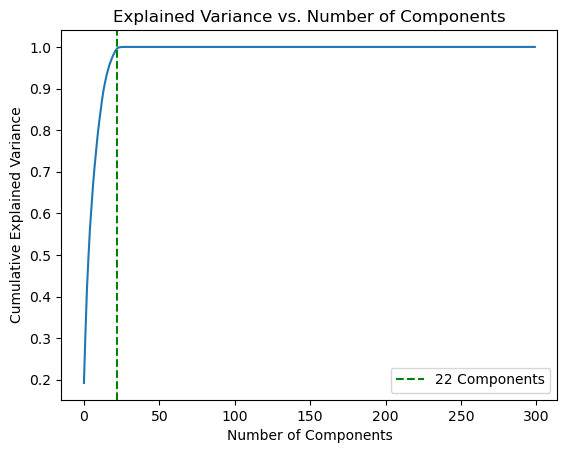

<Figure size 640x480 with 0 Axes>

In [21]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Fit PCA on scaled data
pca = PCA().fit(X_train_scaled)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the cumulative explained variance
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')

num_components_99 = np.argmax(cumulative_variance >= 0.99) + 1
# Add a vertical line at the point where it explains 95% variance
plt.axvline(x=num_components_99, color='g', linestyle='--', label=f'{num_components_99} Components')
# Annotate the plot to show where the peak occurs
#plt.text(num_components_99, cumulative_variance[num_components_99 - 1], f'{num_components_99} components', 
        # horizontalalignment='right', verticalalignment='bottom')

plt.legend()
plt.show()
plt.savefig('PCA feature selection.png')

# Choose components to retain 95% of variance
pca = PCA(n_components=0.99)  # Retains components that explain 95% of variance
X_train_reduced = pca.fit_transform(X_train_scaled)
X_test_reduced = pca.fit_transform(X_test_scaled)


### Dealing with the class imbalances

In [22]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_reduced, y_train)

### Using the Principal components with the highest explained variance on the balanced data for modeling

In [35]:
xgb_classifier = XGBClassifier(n_estimators=200,  max_depth = 20, subsample = 0.8,
                               learning_rate=0.1, random_state = 42, n_jobs=-1)  
xgb_classifier.fit(X_train_balanced, y_train_balanced)
xgb_pred = xgb_classifier.predict(X_test_reduced)

print("\nXGBoost Classifier Results:")
print(classification_report(y_test, xgb_pred, target_names=['Negative', 'Neutral', 'Positive']))

KeyboardInterrupt: 

## Hyperparameter Tuning with Genetic Algorithm

In [36]:
!pip install deap scikit-learn xgboost numpy
from deap import base, creator, tools, algorithms
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
import numpy as np
import random

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 4.3 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for deap: filename=deap-1.4.1-cp311-cp311-macosx_11_0_arm64.whl size=104159 sha256=ca831278a5711b446e6267950f372eb2dfed4320b13ec08702989d1ffd054f86
  Stored in directory: /Users/eosamau/Library/Caches/pip/wheels/f8/64/b8/65eacfbff3024ae2e2beb22e691d5c8abb89fbd863b8049b5f
Successfully built deap


In [37]:
param_space = {
    'n_estimators': (50, 500),
    'max_depth': (3, 20),
    'learning_rate': (0.01, 0.3),
    'subsample': (0.5, 1.0),
    'colsample_bytree': (0.5, 1.0),
    'gamma': (0, 5),
    'min_child_weight': (1, 10)
}

In [38]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

# Define genes
toolbox.register("n_estimators", random.randint, param_space['n_estimators'][0], param_space['n_estimators'][1])
toolbox.register("max_depth", random.randint, param_space['max_depth'][0], param_space['max_depth'][1])
toolbox.register("learning_rate", random.uniform, param_space['learning_rate'][0], param_space['learning_rate'][1])
toolbox.register("subsample", random.uniform, param_space['subsample'][0], param_space['subsample'][1])
toolbox.register("colsample_bytree", random.uniform, param_space['colsample_bytree'][0], param_space['colsample_bytree'][1])
toolbox.register("gamma", random.uniform, param_space['gamma'][0], param_space['gamma'][1])
toolbox.register("min_child_weight", random.randint, param_space['min_child_weight'][0], param_space['min_child_weight'][1])

# Define individual and population
toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.n_estimators, toolbox.max_depth, toolbox.learning_rate,
                  toolbox.subsample, toolbox.colsample_bytree, toolbox.gamma,
                  toolbox.min_child_weight), n=1)

toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [39]:
def evaluate(individual, X, y):
    n_estimators, max_depth, learning_rate, subsample, colsample_bytree, gamma, min_child_weight = individual
    
    model = XGBClassifier(n_estimators=n_estimators,
                          max_depth=max_depth,
                          learning_rate=learning_rate,
                          subsample=subsample,
                          colsample_bytree=colsample_bytree,
                          gamma=gamma,
                          min_child_weight=min_child_weight,
                          random_state=42,
                          n_jobs=-1)
    
    scores = cross_val_score(model, X, y, cv=5, scoring='f1_macro')
    return scores.mean(),

toolbox.register("evaluate", evaluate, X=X_train_reduced, y=y_train)

In [40]:
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

In [45]:
from tqdm import tqdm

# Set up the genetic algorithm parameters
population = toolbox.population(n=50)
ngen = 10

# Wrap the genetic algorithm with tqdm
with tqdm(total=ngen, desc="Generations") as pbar:
    for gen in range(ngen):
        # Perform one step of the genetic algorithm
        algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=1, verbose=False)
        
        # Update the progress bar
        pbar.update(1)

# Get the best individual
best_individual = tools.selBest(population, k=1)[0]

# Extract best parameters
best_params = {
    'n_estimators': best_individual[0],
    'max_depth': best_individual[1],
    'learning_rate': best_individual[2],
    'subsample': best_individual[3],
    'colsample_bytree': best_individual[4],
    'gamma': best_individual[5],
    'min_child_weight': best_individual[6]
}

print("Best parameters found:", best_params)

Generations:   0%|          | 0/10 [00:38<?, ?it/s]


KeyboardInterrupt: 

In [44]:
best_xgb = XGBClassifier(**best_params, random_state=42, n_jobs=-1)
best_xgb.fit(X_train_reduced, y_train)

# Evaluate on test set
y_pred = best_xgb.predict(X_test_reduced)
print(classification_report(y_test, y_pred, target_names=['Negative', 'Neutral', 'Positive']))

              precision    recall  f1-score   support

    Negative       0.27      0.08      0.12      7961
     Neutral       0.12      0.00      0.01      4899
    Positive       0.60      0.93      0.73     19400

    accuracy                           0.58     32260
   macro avg       0.33      0.34      0.29     32260
weighted avg       0.45      0.58      0.47     32260



### Feature Selection

In [46]:
from sklearn.feature_selection import SelectFromModel

selector = SelectFromModel(best_xgb, prefit=True)
X_train_selected = selector.transform(X_train_balanced)
X_test_selected = selector.transform(X_test_reduced)

best_xgb.fit(X_train_selected, y_train_balanced)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.73140111169093, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.8423975787654725,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2327980056459208,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=18, max_leaves=None,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=150, n_jobs=-1,
              num_parallel_tree=None, objective='multi:softprob', ...)

### Other Algorithms

In [47]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

rf = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42, n_jobs=-1)
rf.fit(X_train_selected, y_train_balanced)

voting_clf = VotingClassifier(
    estimators=[('xgb', best_xgb), ('rf', rf)],
    voting='soft'
)
voting_clf.fit(X_train_selected, y_train_balanced)

VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.73140111169093,
                                            device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            gamma=0.8423975787654725,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_co...
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=18,
                                            max_leaves=None, min_child_weight=4,
                                            missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=150, n_jobs=-1,
                                            num_parallel_tree=None,
                                            objective='multi:softprob', ...)),
                             ('rf',
                              RandomForestClassifier(max_depth=10,
                                                     n_estimators=200,
                                                     n_jobs=-1,
                                                     random_state=42))],
                 voting='soft')

### Evaluate Models

In [48]:
for name, model in [('XGBoost', best_xgb), ('Random Forest', rf), ('Voting Classifier', voting_clf)]:
    predictions = model.predict(X_test_selected)
    print(f"\n{name} Results:")
    print(classification_report(y_test, predictions, target_names=['Negative', 'Neutral', 'Positive']))


XGBoost Results:
              precision    recall  f1-score   support

    Negative       0.25      0.28      0.26      7961
     Neutral       0.16      0.23      0.19      4899
    Positive       0.60      0.50      0.55     19400

    accuracy                           0.40     32260
   macro avg       0.34      0.34      0.33     32260
weighted avg       0.45      0.40      0.42     32260


Random Forest Results:
              precision    recall  f1-score   support

    Negative       0.23      0.25      0.24      7961
     Neutral       0.16      0.31      0.21      4899
    Positive       0.61      0.43      0.51     19400

    accuracy                           0.37     32260
   macro avg       0.33      0.33      0.32     32260
weighted avg       0.45      0.37      0.40     32260


Voting Classifier Results:
              precision    recall  f1-score   support

    Negative       0.24      0.26      0.25      7961
     Neutral       0.16      0.25      0.19      4899
    P

### Cross Validation

In [49]:
from sklearn.model_selection import cross_val_score

for name, model in [('XGBoost', best_xgb), ('Random Forest', rf), ('Voting Classifier', voting_clf)]:
    scores = cross_val_score(model, X_train_selected, y_train_balanced, cv=5, scoring='f1_macro')
    print(f"{name} Cross-validation F1-macro: {scores.mean():.3f} (+/- {scores.std() * 2:.3f})")

XGBoost Cross-validation F1-macro: 0.701 (+/- 0.011)
Random Forest Cross-validation F1-macro: 0.454 (+/- 0.029)
Voting Classifier Cross-validation F1-macro: 0.682 (+/- 0.011)


XGBoost has the best performance overall with the highest F1-macro score (0.701) and consistent results across folds. It is likely the best choice for this task.
The Voting Classifier comes in second, showing strong performance close to XGBoost, possibly because it incorporates XGBoost as one of its models.
Random Forest performs significantly worse with an F1-macro score of 0.454, suggesting it may not be the best choice for this particular task or requires hyperparameter tuning.


### Learning curves

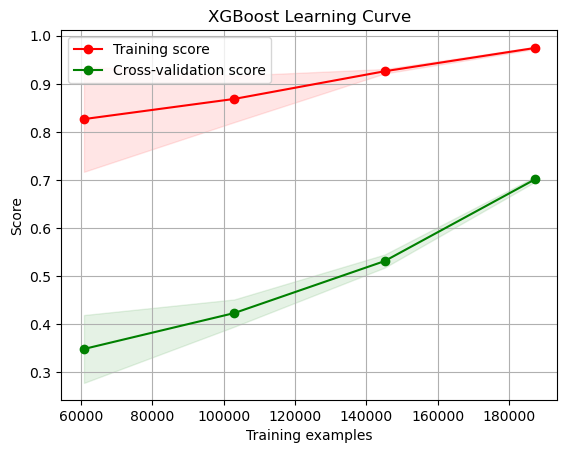

In [52]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='f1_macro')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    return plt

plot_learning_curve(best_xgb, "XGBoost Learning Curve", X_train_selected, y_train_balanced, cv=5)
plt.savefig('Learning Curves.png')
plt.show()

##### More data will improve the model!

Training Score (Red Line):
The red line represents the model's performance on the training data.
The training score starts high (~0.83) and increases as more training examples are added, reaching near perfect performance (~0.96).
This is typical in machine learning, where models tend to perform very well on training data as they learn the patterns of the training set.
Cross-Validation Score (Green Line):
The green line represents the performance on the cross-validation (test) set.
Initially, the cross-validation score is quite low (~0.32), but it steadily increases as the training examples increase.
As more training data is added, the cross-validation score improves significantly, reaching around 0.70 at the highest number of training examples.
This indicates that the model is generalizing better as more data is provided.
